<a href="https://colab.research.google.com/github/siddhaling/3D-Visualization-of-Sentiment-Measures-and-Classification-using-Combined-Classifier-for-Reviews/blob/master/ACO_AI2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ant Colony Optimization on Uber Mumbai data

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import networkx as nx

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%cd drive/My\ Drive/Datasets/Uber

/content/drive/My Drive/Datasets/Uber


## Exploratory Data Analysis

In [0]:
df_hod = pd.read_csv('mumbai-hexclusters-2019-3-OnlyWeekdays-HourlyAggregate.csv')
df_dow = pd.read_csv('mumbai-hexclusters-2019-3-WeeklyAggregate.csv')
id_names =  json.load(open('mumbai_hexclusters.json'))

In [0]:
df_hod.head()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,415,193,15,1622.84,367.54,1589.22,1.22
1,406,283,15,2193.82,692.48,2131.38,1.25
2,408,263,15,3642.02,786.30,3564.44,1.23
3,417,173,15,2205.73,811.80,2081.39,1.39
4,407,273,15,5963.45,1036.01,5879.98,1.18


In [0]:
df_dow.head()

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,489,540,6,2489.35,1098.46,2283.17,1.51
1,305,137,4,7602.00,1872.38,7366.93,1.29
2,448,27,5,2816.78,977.26,2661.56,1.40
3,443,77,5,3131.48,916.30,2993.87,1.36
4,442,87,5,2190.09,507.48,2138.62,1.24


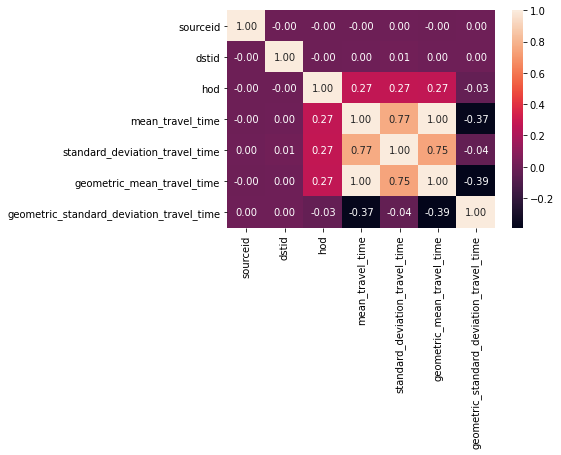

In [0]:
sns.heatmap(df_hod.corr(), annot=True, fmt=".2f")
plt.show()

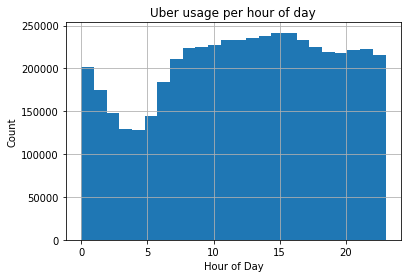

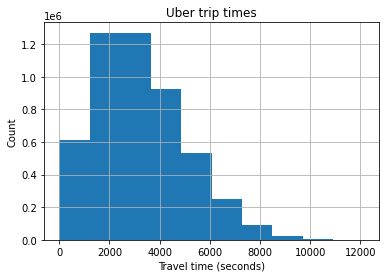

In [0]:
df_hod.hist(column='hod', bins=24)
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Uber usage per hour of day')
plt.show()

df_hod.hist(column='mean_travel_time')
plt.xlabel('Travel time (seconds)')
plt.ylabel('Count')
plt.title('Uber trip times')
plt.show()

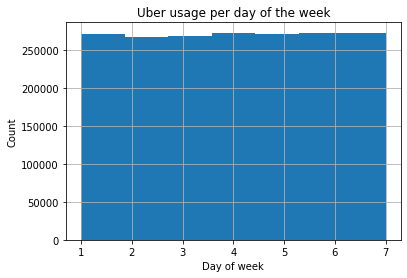

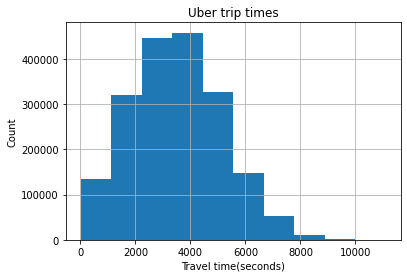

In [0]:
df_dow.hist(column='dow', bins=7)
plt.xlabel('Day of week')
plt.ylabel('Count')
plt.title('Uber usage per day of the week')
plt.show()

df_dow.hist(column='mean_travel_time')
plt.xlabel('Travel time(seconds)')
plt.ylabel('Count')
plt.title('Uber trip times')
plt.show()

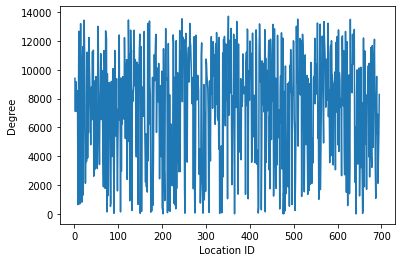

In [0]:
source_deg = dict(df_hod['sourceid'].value_counts())
source_deg = sorted(source_deg.items())
x, y = zip(*source_deg)
plt.plot(x, y)
plt.xlabel('Location ID')
plt.ylabel('Degree')
plt.show()

In [0]:
def get_name(id):
  for hex in id_names['features']:
    if hex['properties']['MOVEMENT_ID'] == str(id):
      return (hex['properties']['DISPLAY_NAME'])

In [0]:
source_deg = sorted(source_deg, key=lambda x: x[1])
print("Most common starting locations: ")
for place in source_deg[:10]:
  name = get_name(place[0])
  if name == "Unnamed Road":
      continue
  print(place[0], name)

Most common starting locations: 
476 Kolegaon-Dombivali Rd
365 Madh - Marve Rd
478 vipul waykar b401
331 0, Nandivili Road, Omsai Chawl, Bhopar Goan
657 BARC Rd
90 Manori Masjid Road
252 Global Pagoda Road


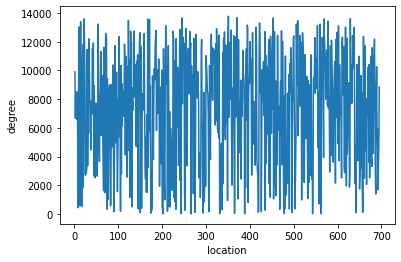

In [0]:
dst_deg = dict(df_hod['dstid'].value_counts())
dst_deg = sorted(dst_deg.items())
x, y = zip(*dst_deg)
plt.plot(x, y)
plt.xlabel('location')
plt.ylabel('degree')
plt.show()

In [0]:
dst_deg = sorted(dst_deg, key=lambda x: x[1])
print("Most common destinations: ")
for place in dst_deg[:10]:
  name = get_name(place[0])
  if name == "Unnamed Road":
      continue
  print(place[0], name)

Most common destinations: 
562 School Rd
331 0, Nandivili Road, Omsai Chawl, Bhopar Goan
543 Killeshwar Mahadev Marg
365 Madh - Marve Rd
478 vipul waykar b401
174 0, Walkeshwar Rd, Raj Bhavan, Malabar Hill


# Implementing Ant Colony Optimization

In [0]:
import random
import numpy as np

class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        self.matrix = cost_matrix
        self.rank = rank
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]


class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    def solve(self, graph: Graph, verbose: bool = False):
        best_cost = float('inf')
        best_solution = []
        avg_costs = []
        best_costs = []
        for gen in range(self.generations):
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            curr_cost = []
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                curr_cost.append(ant.total_cost)
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            best_costs.append(best_cost)
            avg_costs.append(np.mean(curr_cost))
            if verbose:
                print('Generation #{} best cost: {}, avg cost: {}, path: {}'.format(
                    gen+1, best_cost, avg_costs[-1], best_solution))
        return best_solution, best_cost, avg_costs, best_costs


class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []
        self.pheromone_delta = []
        self.allowed = [i for i in range(graph.rank)]
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in range(graph.rank)]
        start = random.randint(0, graph.rank - 1)
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][i] ** self.colony.beta
        probabilities = [0 for i in range(self.graph.rank)]
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    def _update_pheromone_delta(self):
        self.pheromone_delta = [
            [0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

In [0]:
dow = 5
locations = random.sample(list(df_dow.sourceid.unique()), k=50)
print("Locations:")
for _ in locations:
  print(get_name(_))

Locations:
0, Relief Rd, Jankalyan CHS, Bangur Nagar, Goregaon West
Gaimukh Mandir
BARC Rd
Mumbai - Agra National Hwy
Unnamed Road
Vardhaman Palace
100, Uran Rd, Sector 32, Seawoods
Gopal Apartment B-Wing
0, Gupha Rd, Janata Colony, Jogeshwari East
148B, Juhu Tara Rd, Airport Area, Juhu
300, Lamington Rd, Grant Road East, Shapur Baug, Girgaon
Sewri - Chembur Rd
Unnamed Road
Kopra Rd
B/15, Dargah Road, Shantiniketan Society, Tulshet Pada, Mulund West
D-15, Madh - Marve Rd, Bhati Gaon, Madh
Uttan Rd
700-754, Dr Ghanti Rd, Central Railway Colony, Parsee Colony, Dadar
Niwara Society
0, Pandurang Budhkar Marg, Worli, Lower Parel
WING-B
Shahid Bhagat Singh Rd
Roopchand Apartments
0, Navpada
3D-102
A-10, Mithaghar Rd, Tridal Society, Patil Nagar, LIC Housing Colony, Mulund East
200, Station Road, Railway Staff Quarters, Naupada, Bandra East
C 537, Pawane Village Rd, T.T.C. Industrial Area, MIDC Industrial Area, Pawne
SV Rd
300, Balkrishna Nakashe Marg, Janata Nagar, Tardeo
0/1, MGM School Mar

In [0]:
df = df_dow.loc[df_dow['dow'] == dow][['sourceid', 'dstid', 'mean_travel_time']]
df = df.loc[df['sourceid'].isin(locations) & df['dstid'].isin(locations)]
df

,sourceid,dstid,mean_travel_time
2922,421,59,3237.27
4327,9,100,4511.68
6064,87,40,3646.03
7141,59,685,5602.59
7197,59,447,3200.57
...,...,...,...
1885540,100,533,7214.73
1887146,584,281,5209.32
1887993,542,106,3787.10
1890416,374,198,2897.87


In [0]:
remapped_locations = { y:x for x,y in enumerate(locations) }
df['sourceid'].replace(remapped_locations, inplace=True)
df['dstid'].replace(remapped_locations, inplace=True)
df

,sourceid,dstid,mean_travel_time
2922,11,20,3237.27
4327,30,39,4511.68
6064,27,21,3646.03
7141,20,18,5602.59
7197,20,17,3200.57
...,...,...,...
1885540,39,19,7214.73
1887146,26,1,5209.32
1887993,14,13,3787.10
1890416,34,35,2897.87


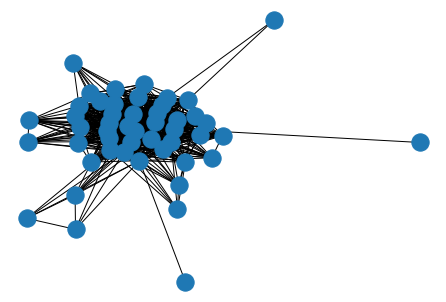

In [0]:
g = nx.from_pandas_edgelist(df, source='sourceid', target='dstid')
nx.draw(g)

In [0]:
max_time = int(df.loc[df['mean_travel_time'].idxmax()]['mean_travel_time'])
cost_matrix = [[ max_time for _ in range(len(locations))] for _ in range(len(locations))]
for index, row in df.iterrows():
  if row['sourceid']==row['dstid']:
    cost_matrix[int(row['sourceid'])][int(row['dstid'])] = 0
    continue
  cost_matrix[int(row['sourceid'])][int(row['dstid'])] = int(row['mean_travel_time'])

print(np.matrix(cost_matrix))

[[   0 4661 8870 ... 3510 8870 8870]
 [3612    0 8870 ... 5392 5868 2474]
 [8870 8870 8870 ... 8870 8870 8870]
 ...
 [3632 8870 8870 ...    0 8870 5464]
 [8870 5987 8870 ... 8870    0 3559]
 [8870 2318 8870 ... 4402 3022    0]]


In [0]:
ant_count = 20
alpha = 1.0
beta = 10.0
rho = 0.1
q = 10000
g = 15
aco = ACO(ant_count=ant_count, generations=g, alpha=alpha,beta=beta, rho=rho, q=q, strategy=2)

In [0]:
graph = Graph(cost_matrix, len(locations))

In [0]:
best_path, cost, avg_costs, best_costs = aco.solve(graph, True)

Generation #1 best cost: 108546.0, avg cost: 119201.25, path: [30, 5, 27, 6, 13, 40, 41, 32, 11, 2, 48, 39, 18, 21, 37, 38, 7, 49, 31, 43, 19, 17, 36, 3, 25, 20, 35, 14, 22, 34, 44, 1, 24, 28, 46, 8, 0, 15, 42, 26, 47, 29, 10, 23, 9, 12, 4, 16, 45, 33]
Generation #2 best cost: 102278.0, avg cost: 115599.6, path: [37, 18, 39, 21, 48, 31, 49, 43, 16, 45, 33, 7, 22, 34, 44, 1, 24, 28, 46, 8, 0, 15, 42, 26, 47, 19, 29, 10, 17, 11, 2, 12, 4, 25, 20, 35, 14, 3, 36, 23, 9, 6, 13, 40, 41, 32, 5, 30, 27, 38]
Generation #3 best cost: 102278.0, avg cost: 115663.65, path: [37, 18, 39, 21, 48, 31, 49, 43, 16, 45, 33, 7, 22, 34, 44, 1, 24, 28, 46, 8, 0, 15, 42, 26, 47, 19, 29, 10, 17, 11, 2, 12, 4, 25, 20, 35, 14, 3, 36, 23, 9, 6, 13, 40, 41, 32, 5, 30, 27, 38]
Generation #4 best cost: 102278.0, avg cost: 116847.55, path: [37, 18, 39, 21, 48, 31, 49, 43, 16, 45, 33, 7, 22, 34, 44, 1, 24, 28, 46, 8, 0, 15, 42, 26, 47, 19, 29, 10, 17, 11, 2, 12, 4, 25, 20, 35, 14, 3, 36, 23, 9, 6, 13, 40, 41, 32, 5, 3

In [0]:
print("Optimal Path: Time=" + str(cost/60/60) +" hours")
def get_key(val): 
    for key, value in remapped_locations.items(): 
         if val == value: 
             return key
for place in best_path:
  print(get_name(get_key(place)))

Optimal Path: Time=28.04861111111111 hours
SV Rd
3D-102
0-27, Bimbisar Nagar Rd, Bimbisar Nagar, Goregaon East
0, Gupha Rd, Janata Colony, Jogeshwari East
0, Relief Rd, Jankalyan CHS, Bangur Nagar, Goregaon West
D-15, Madh - Marve Rd, Bhati Gaon, Madh
Patil Gally
200, Station Road, Railway Staff Quarters, Naupada, Bandra East
General Arunkumar Vaidya Marg
0, Pandurang Budhkar Marg, Worli, Lower Parel
300, Balkrishna Nakashe Marg, Janata Nagar, Tardeo
300, Lamington Rd, Grant Road East, Shapur Baug, Girgaon
700-754, Dr Ghanti Rd, Central Railway Colony, Parsee Colony, Dadar
Sewri - Chembur Rd
BARC Rd
Unnamed Road
Mohane Rd
RL-140, Kalyan Rd, Milap Nagar, Dombivli East
Niwara Society
Shahid Bhagat Singh Rd
Diva Manpada Rd
Diva Shil Rd
C 537, Pawane Village Rd, T.T.C. Industrial Area, MIDC Industrial Area, Pawne
Vardhaman Palace
0/1, MGM School Marg, Sector 8, Nerul West
100, Uran Rd, Sector 32, Seawoods
Kopra Rd
Utsav Chowk - CISF Rd
900/2, Uran Rd, Mominpada, Old Panvel, Panvel
0, Trive

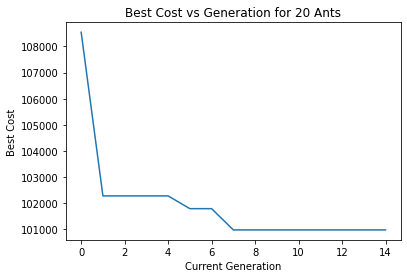

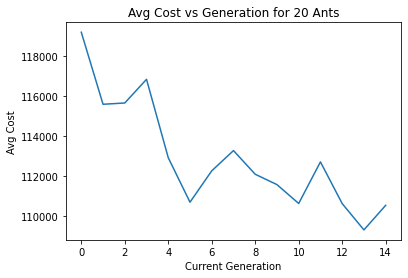

In [0]:
x_values = [i for i in range(g)]
plt.title("Best Cost vs Generation for " + str(ant_count) + " Ants")
plt.ylabel("Best Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, best_costs)
plt.show()

x_values = [i for i in range(g)]
plt.title("Avg Cost vs Generation for " + str(ant_count) + " Ants")
plt.ylabel("Avg Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, avg_costs)
plt.show()